# Extracting features from thermal images of copper grains

This demo analyzes thermal images of copper grains.
The aim of the research is to extract from images features that can be useful in
the grains classification.
The grains presented in this work come from [Sysmel](http://sysmel.pl) project
co-created by the Silesian University of Technology.

In [26]:
from inspect import getsource
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.color import rgb2gray

from blob_series_tracker import (count_blobs_with_all_methods, find_blob_series,
                                 ratio_of_remaining_blobs_in_stages)

from img_processing import (crop_ui, default_img_set,
                            full_prepare, load_img_series)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## A look at sample measurement series

The project is based on *active thermography* technique.
This approach of using thermovision consists in heating objects and then
observing their cooling process.
During experiments it was decided to heat up every sample of grains for one
minute using halogen lamp.
The cooling process was recorded for four minutes.
At begging of every minute of recording a still was exported.
In result, a single measurement contains five images of a sample grain being
cooled down.
Let's load such a series of images and take a look.
To make images cleaner we will crop then to remove the frame added by camera
software. 

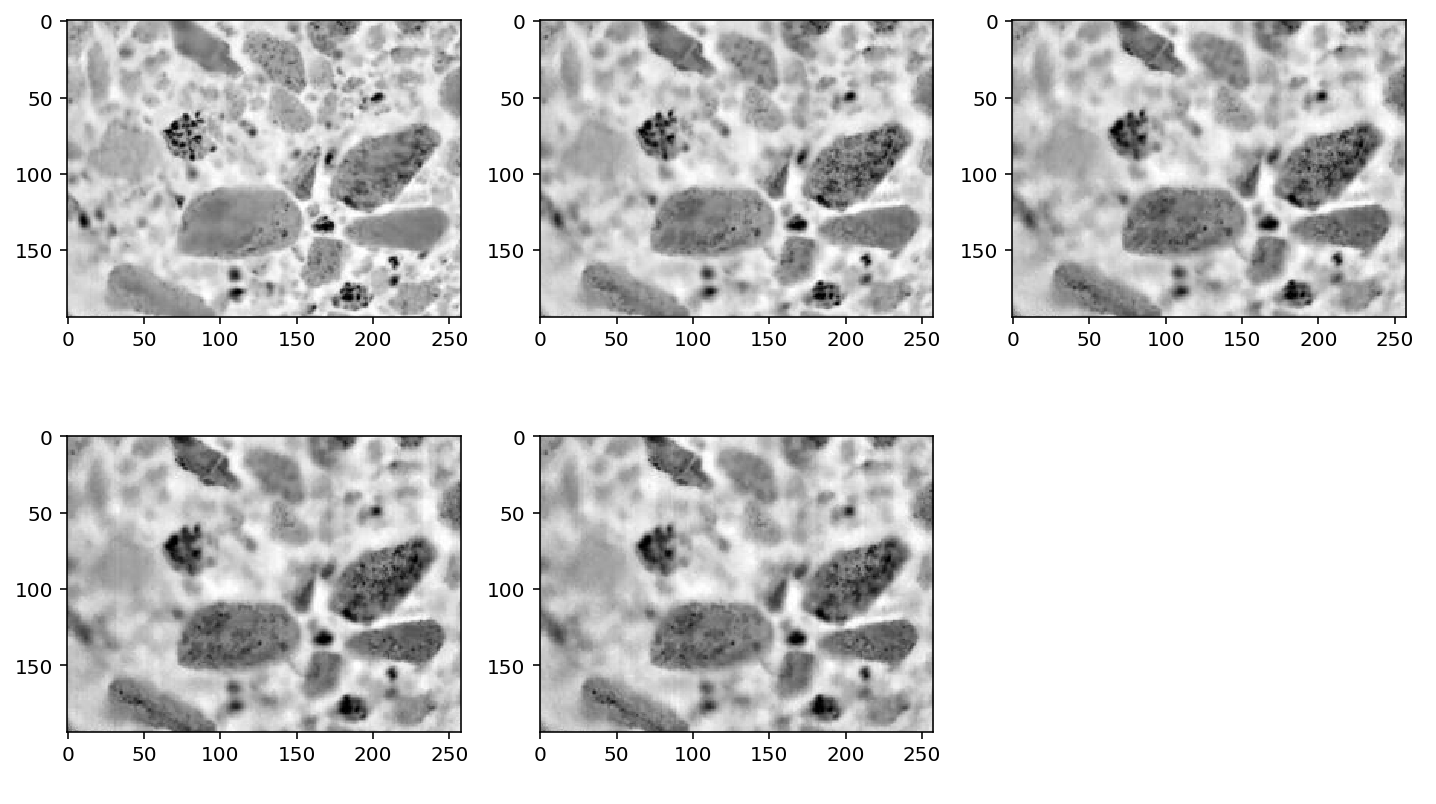

In [11]:
# Load images
imgs = load_img_series('img/119_E5R')
# Prepare images for processing
imgs_prep = [full_prepare(img) for img in imgs]
# Prepare cropped images for displaying
imgs_crop = [crop_ui(rgb2gray(img)) for img in imgs]

_, ax = plt.subplots(2, 3, figsize=(12, 7))
ax = ax.flatten()
for a, img in zip(ax, imgs_crop):
    a.imshow(img, cmap=plt.get_cmap('gray'))
ax[-1].set_axis_off()

We can see that with the time passing the image becomes blurrier.
It is caused by the increasing entropy of the grains.
As the time passes the energy in the heated grains starts to dissipate and
thermal details on the image begin to fade away.
A feature characterizing each class of grains should be selected to perform the
classification.
It has been decided that the best idea is to track the number of spots with low
thermal emissivity.
On the image they are represented as small black dots.

## Detecting and tracking low emissivity spots

The following step is to develop an algorithm that detects and tracks these
spots.
This notebook presents how the points are detected and compares different ways
of finding them.
There are three ways of counting blobs that are taken under consideration:

1.  Counting all blobs at each stage of cooling process.
1.  Counting and tracking only the blobs that were present from the begging of
    the cooling process.
1.  Tracking only the blobs that were present from the begging of the cooling
    process and computing how much of them remain relative to their initial number.


The function `find_blob_series` takes a set of photos and detects the spots with
low emissivity.
It can either detect all blobs at every stage of colling down process or track
the spots that were present only from the beginning of the footage.
This option is determined by `only_remaining` parameter which defaults to
`True`.
We will investigate how the function works in two modes on the sample image
series.

First let's find all blobs at every stage with the `only_remaining` parameter
set to `False` and plot a map of the detected spots.

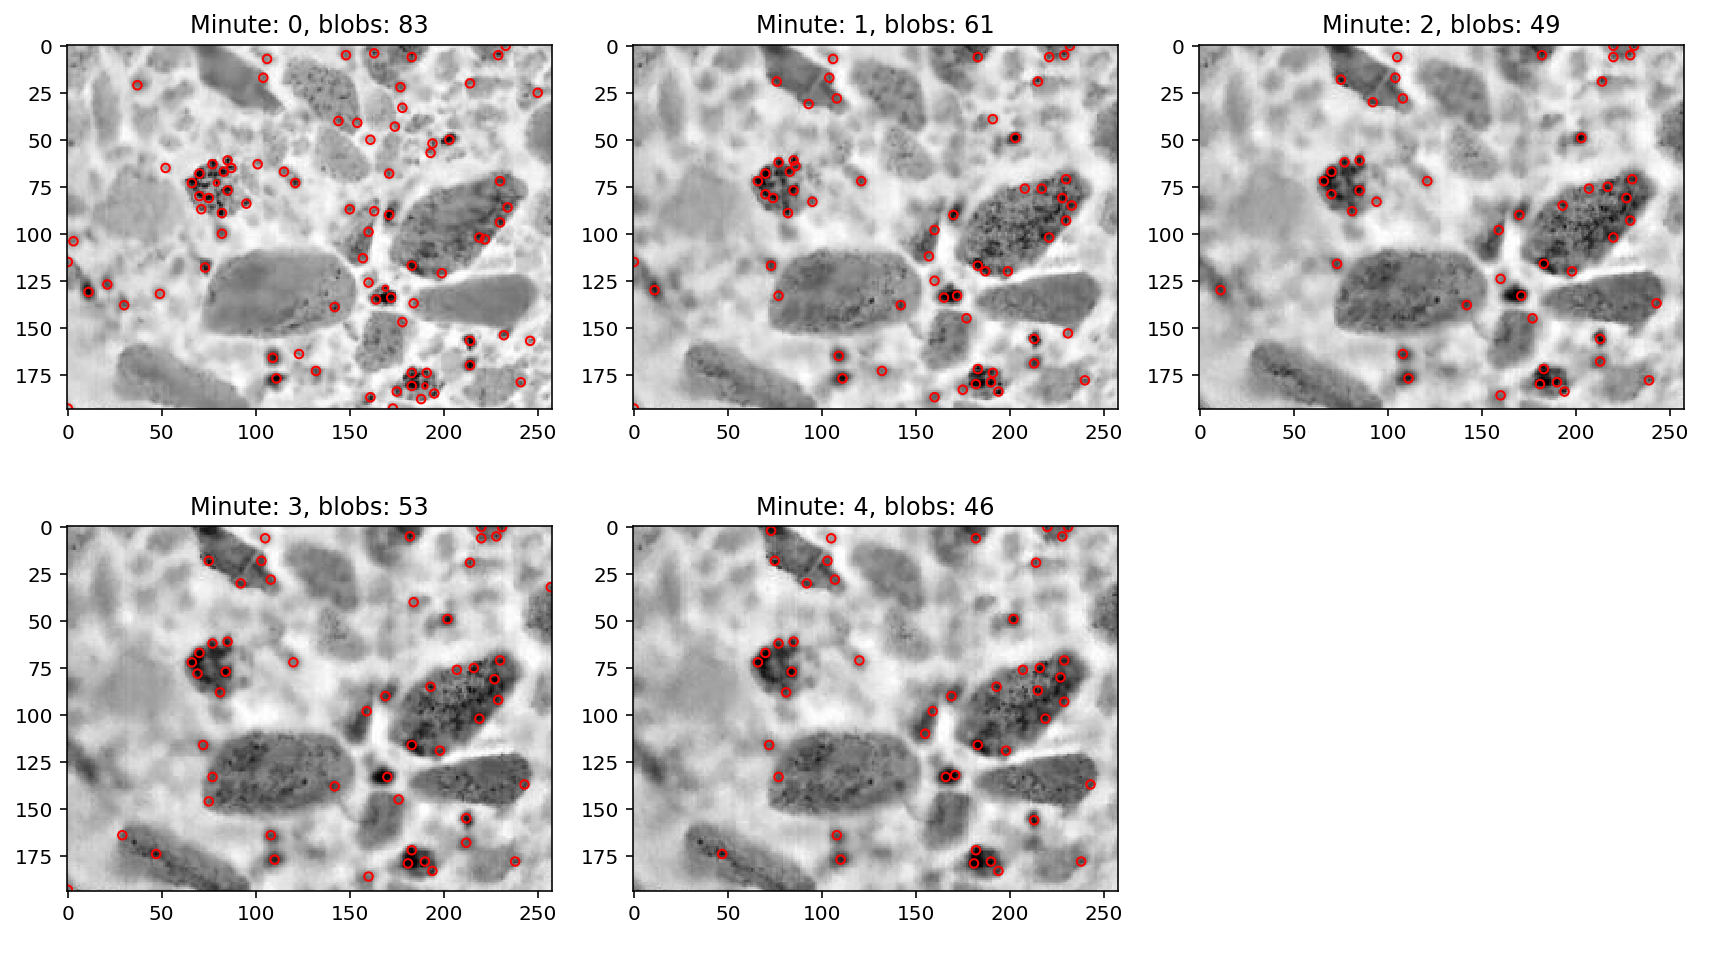

In [12]:
stages_all = find_blob_series(imgs_prep, only_remaining=False)

_, ax = plt.subplots(2, 3, figsize=(12, 7))
ax = ax.flatten()
for idx, (stage, img) in enumerate(zip(stages_all, imgs_crop)):
    ax[idx].imshow(img, cmap=plt.get_cmap('gray'))
    ax[idx].set_title("Minute: {}, blobs: {}".format(idx, len(stage)))
    for blob in stage:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='r', fill=False)
        ax[idx].add_patch(c)
ax[-1].set_axis_off()
plt.tight_layout()

As suspected the number of blobs is decreasing with time.
Nevertheless, there are few spots that appear only in the later stages of
cooling.
We can see it better if we call the function with `only_remaining` parameter set
to `True` (which is the default value).
This method will track only the blobs that are present in the image from the
first stage of cooling process.
Additionally we will mark the newly found spots on the same set of images.
The red points will indicate the blobs tracked from the beginning of the cooling
process whereas the blue ones will be the newly detected blobs in later stages.

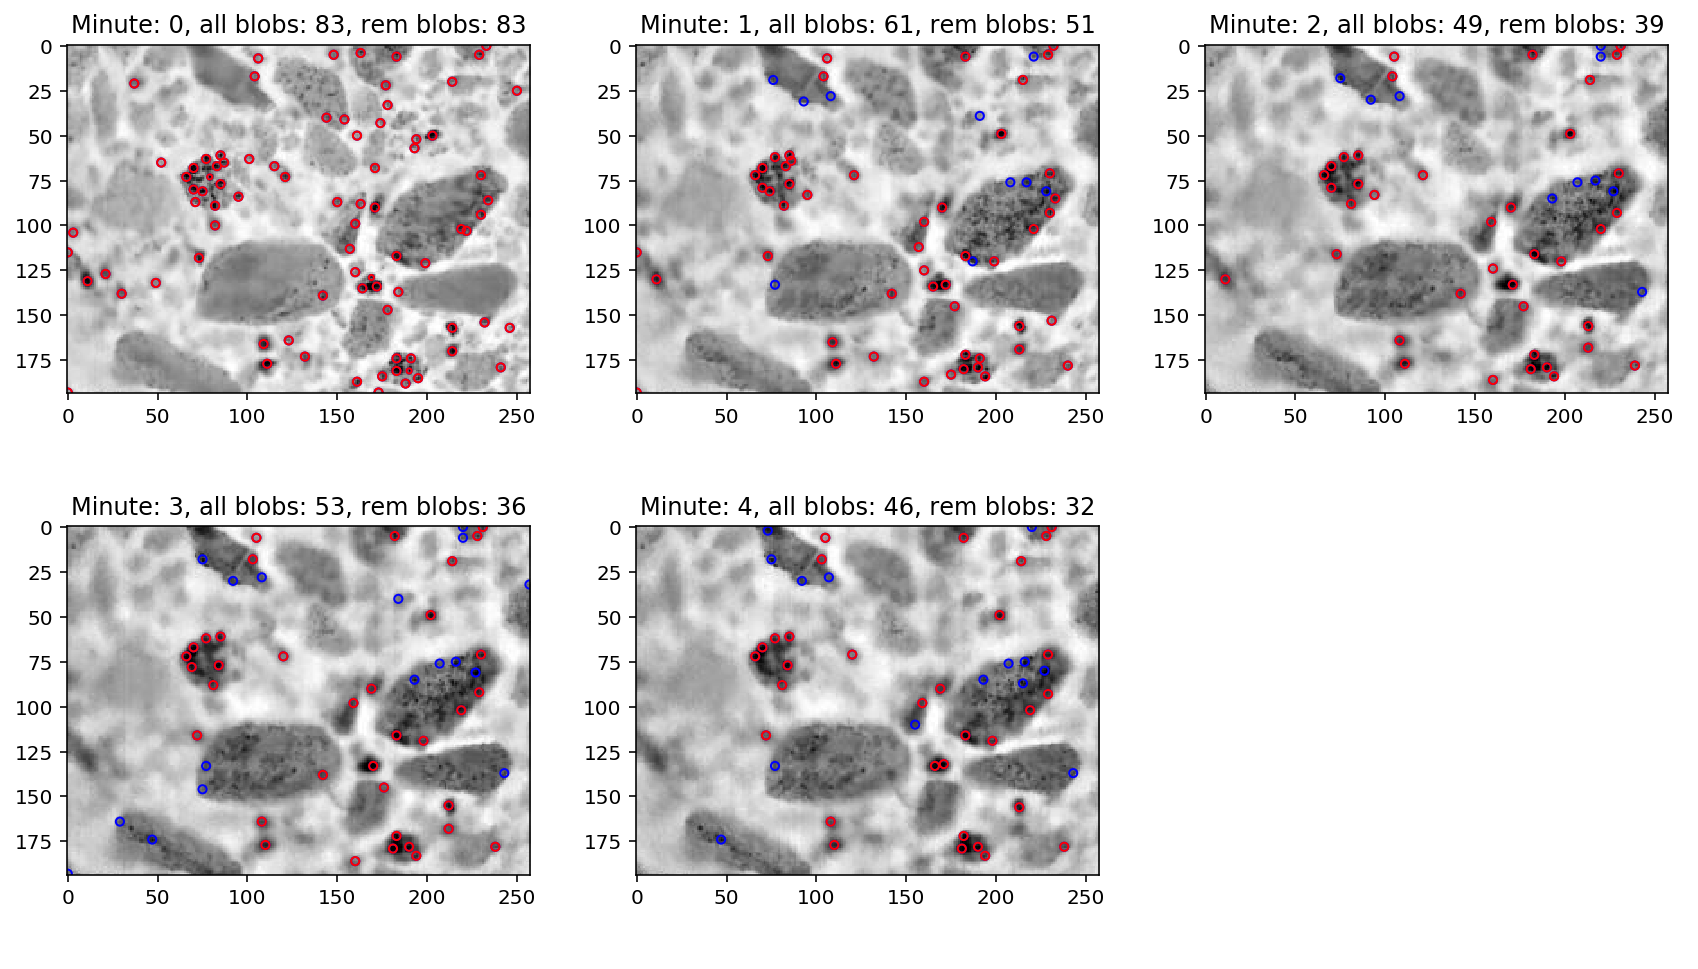

In [22]:
stages_rem = find_blob_series(imgs_prep)

_, ax = plt.subplots(2, 3, figsize=(12, 7))
ax = ax.flatten()

loop_set = enumerate(zip(stages_rem, stages_all, imgs_crop))
for idx, (stage_rem, stage_all, img) in loop_set:
    ax[idx].imshow(img, cmap=plt.get_cmap('gray'))
    ax[idx].set_title("Minute: {}, all blobs: {}, rem blobs: {}".
                      format(idx, len(stage_all), len(stage_rem)))
    for blob_all in stage_all:
        y, x, r = blob_all
        c = plt.Circle((x, y), r, color='b', fill=False)
        ax[idx].add_patch(c)
    for blob_rem in stage_rem:
        y, x, r = blob_rem
        c = plt.Circle((x, y), r, color='r', fill=False)
        ax[idx].add_patch(c)
ax[-1].set_axis_off()
plt.tight_layout()

If you look closely you may see that some spots move a bit with time.
Also as the cooling process progresses the spots that are nearby start to blend.
This causes their center of mass to change place.
We can visualize the blobs tracking in one another way to demonstrate this
behavior.
Let's map positions of tracked blobs in all stages on the image from the start
of the cooling process.

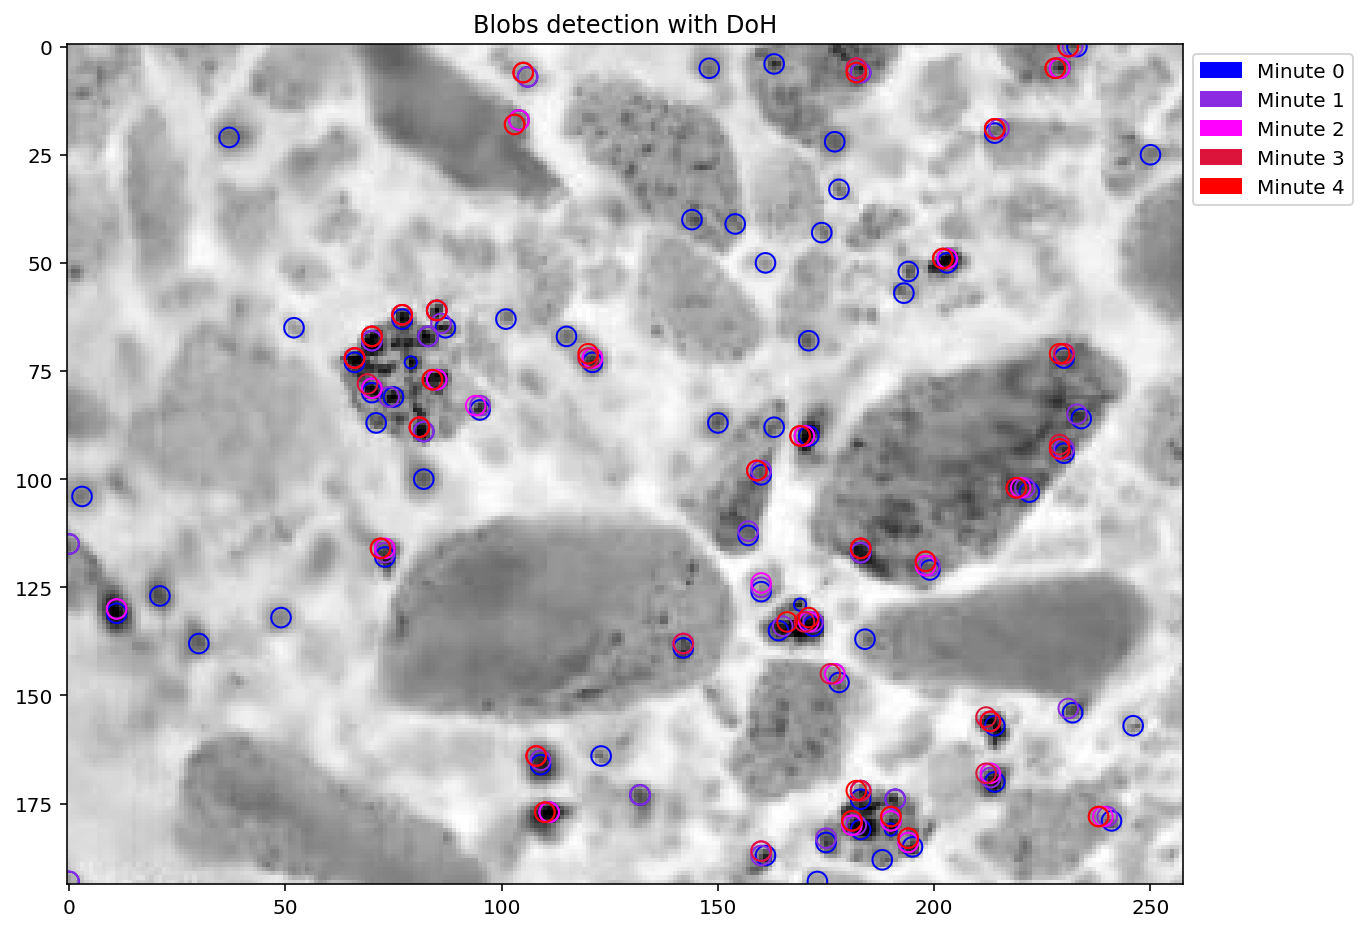

In [24]:
colors = ('blue', 'blueviolet', 'magenta', 'crimson', 'red')
labels = ('Minute 0', 'Minute 1', 'Minute 2', 'Minute 3', 'Minute 4')
_, ax = plt.subplots(1, figsize=(10, 10))
plt.title("Blobs detection with DoH")
plt.imshow(imgs_crop[0], cmap=plt.get_cmap('gray'))
for stage, color in zip(stages_rem, colors):
    for blob in stage:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, fill=False)
        ax.add_patch(c)
legend = [mpatches.Patch(color=color, label=label)
          for color, label in zip(colors, labels)]
plt.legend(handles=legend, loc='upper left', bbox_to_anchor=(1, 1));

If you look closely you may see that some spots move a bit with time.
Also as the cooling process progresses the spots that are nearby start to blend.
This causes their center of mass to change place.
We can visualize the blobs tracking in one another way to demonstrate this
behavior.
Let's map positions of tracked blobs in all stages on the image from the start
of the cooling process.The tracking algorithm has to take into account the fact
that the blobs move or shift their center of mass when merging.
Because of that the tracked spot is counted as persisting on two images if in
the second one it is in proximity of two times its radius.

Last way of counting blobs consists in calculating the number of tracked points
relative to their initial quantity.
This is simply achieved by using the `find_blob_series` with `only_remaining`
set to `True` and calculating the ratios of remaining blobs.

In [15]:
print(ratio_of_remaining_blobs_in_stages(stages_rem))

[1.0, 0.6144578313253012, 0.46987951807228917, 0.43373493975903615, 0.3855421686746988]


## Analysis of number of spots with low emissivity

We took a look at the blob counting and tracking mechanism.
Now it is the time to visualize this feature and review it's usefulness in
grains classification.
To do so, we will plot the number of blobs versus the time of cooling.
First let's define some plotting utilities.

In [27]:
def plot_blob_stat(samples_set, lebels_set, colors):
    '''Plot blob count versus minutes.'''
    plt.figure()
    for sample_series, sample_label_index in zip(samples_set, lebels_set):
        plt.plot(
            [0, 1, 2, 3, 4],
            sample_series,
            c=colors[sample_label_index],
            linewidth=1.2)


def patch_plot_legend(colors, labels):
    '''Make given plots share their legend entry.'''
    legend = [
        mpatches.Patch(color=color, label=label)
        for color, label in zip(colors, labels)
    ]
    plt.legend(handles=legend)

Right now we can load the whole dataset of images and plot the number of blobs
for each class versus time.
We will plot three charts one for each counting methods.

In [25]:
X, y = default_img_set()
X = [[full_prepare(img) for img in same_sample] for same_sample in X]
Xa, Xr, Xp = count_blobs_with_all_methods(X)

colors = ('r', 'g', 'b', 'y')
labels = ('E5R', 'E6R', 'E11R', 'E16R')

Let's start with counting all blobs at every stage.
The lines indicating classes are not easily separable.
That means they will likely serve as a poor basis for classification.

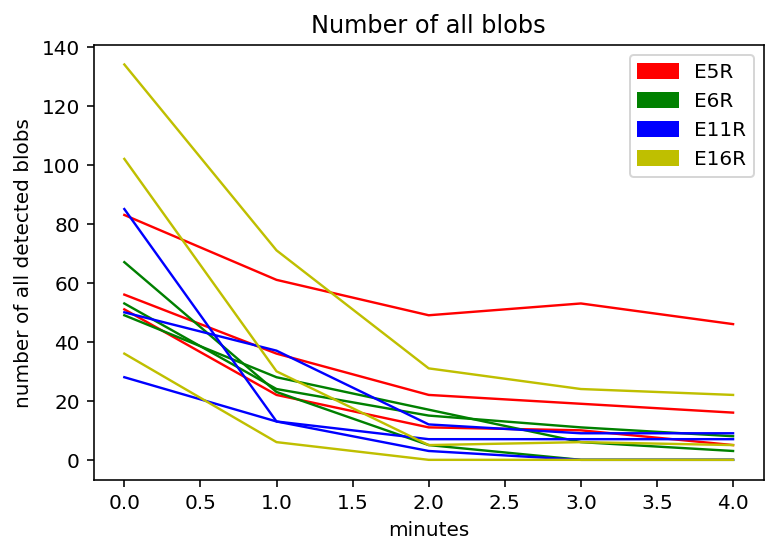

In [25]:
plot_blob_stat(Xa, y, colors)
plt.title('Number of all blobs')
plt.xlabel('minutes')
plt.ylabel('number of all detected blobs')
patch_plot_legend(colors, labels)

Now we will examine the result of counting only the blobs that are present from
the beginning of the cooling process.
This method seems to yield better results.
The plots are closer to being separated.
Moreover the curves that correspond to the same class of grains seem to maintain
similar rate of dissipating.
In other words the plots with same color have similar slopes.

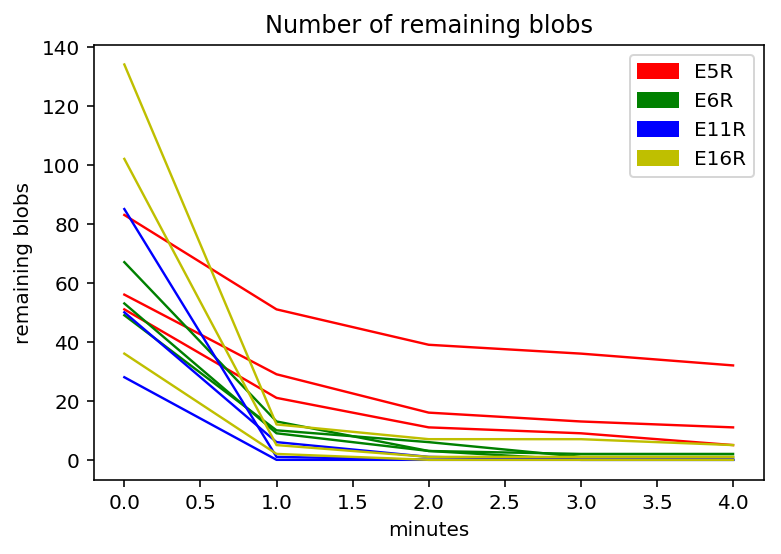

In [17]:
plot_blob_stat(Xr, y, colors)
plt.title('Number of remaining blobs')
plt.xlabel('minutes')
plt.ylabel('remaining blobs')
patch_plot_legend(colors, labels)

Finally, we will plot the ratio of the number of remaining blobs to their
initial quantity.
The curves representing various classes are clearly distinguishable by their
shape.
This hints that this way of counting may be a suitable way of creating input
vector for grains classifying neural network.

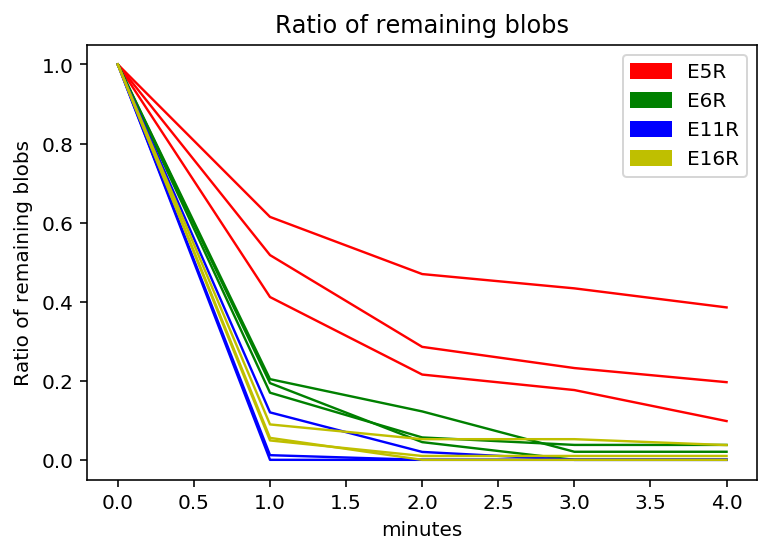

In [28]:
plot_blob_stat(Xp, y, colors)
plt.title('Ratio of remaining blobs')
plt.xlabel('minutes')
plt.ylabel('Ratio of remaining blobs')
patch_plot_legend(colors, labels)

## Conclusion

The developed algorithm of detecting and tracking spots with low thermal
emissivity proves to be suitable for creating input vectors for a neural network.
Among the considered three ways of counting number of blobs the latest one,
consisting in calculating the ratio of tracked spots to their initial quantity
seems to yield the most encouraging results.
The next step is to construct a prototype of a neural network and examine
whether the conclusions derived from the analysis result in applicable
classification outcome.